# 欠拟合与过拟合
##   欠拟合的解决方法：
增加输入特征项  
增加网络参数  
减少正则化参数  

## 过拟合的解决方法：
数据清洗  
增大训练集  
采用正则化  
增大正则化参数  
## 正则化缓解过拟合
正则化在损失函数中引入模型复杂度指标，利用给W加权值，弱化了训练数据的噪声（一般不正则化偏置b）  
##### loss = loss（y与y_）+REGULARIZER * loss（w）
#### 正则化的选择（L1/L2）
$$ loss_{L1}(w) = ∑_i|w_i| $$
L1正则化大概率会使得很多参数变为零，因此该方法可通过稀疏参数，即减少参数的数量，降低复杂度。  
$$ loss_{L2}(w) = ∑_i|w_i^2| $$
L2正则化会使参数接近零但不为零，因此该方法可以减少参数值的大小降低复杂度。  
##### loss(w) = tf.contrib.layers.l1_reglarizer(REGULARIZER)(w)        loss_l1(w)=Σ|Wi|
    eg:
        loss_retularization = []
        loss_retularization.append(tf.nn.l2_loss(w1))
        loss_retularization = tf.reduce_sum(loss_regularization)

epoch: 0 loss: 0.7345467209815979
epoch: 20 loss: 0.07014384120702744
epoch: 40 loss: 0.04063370078802109
epoch: 60 loss: 0.03103024698793888
epoch: 80 loss: 0.027629895135760307
epoch: 100 loss: 0.026115337386727333
epoch: 120 loss: 0.025203466415405273
epoch: 140 loss: 0.02480527199804783
epoch: 160 loss: 0.02410784922540188
epoch: 180 loss: 0.02294393815100193
epoch: 200 loss: 0.022387199103832245
epoch: 220 loss: 0.022929077968001366
epoch: 240 loss: 0.023137563839554787
epoch: 260 loss: 0.023108474910259247
epoch: 280 loss: 0.022853925824165344
epoch: 300 loss: 0.022794650867581367
epoch: 320 loss: 0.02273387648165226
epoch: 340 loss: 0.02272939868271351
epoch: 360 loss: 0.022703757509589195
epoch: 380 loss: 0.022631840780377388
*******predict*******


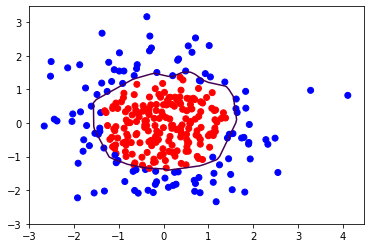

In [1]:
# 导入所需模块
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# 读入数据/标签 生成x_train y_train
df = pd.read_csv('dot.csv')
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c'])

x_train = np.vstack(x_data).reshape(-1,2)
y_train = np.vstack(y_data).reshape(-1,1)

Y_c = [['red' if y else 'blue'] for y in y_train]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型问题报错
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)

# from_tensor_slices函数切分传入的张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

# 生成神经网络的参数，输入层为2个神经元，隐藏层为11个神经元，1层隐藏层，输出层为1个神经元
# 用tf.Variable()保证参数可训练
w1 = tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01, shape=[11]))

w2 = tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01, shape=[1]))

lr = 0.01  # 学习率
epoch = 400  # 循环轮数

# 训练部分
for epoch in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:  # 记录梯度信息

            h1 = tf.matmul(x_train, w1) + b1  # 记录神经网络乘加运算
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1, w2) + b2

            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss = tf.reduce_mean(tf.square(y_train - y))

        # 计算loss对各个参数的梯度
        variables = [w1, b1, w2, b2]
        grads = tape.gradient(loss, variables)

        # 实现梯度更新
        # w1 = w1 - lr * w1_grad tape.gradient是自动求导结果与[w1, b1, w2, b2] 索引为0，1，2，3 
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 每20个epoch，打印loss信息
    if epoch % 20 == 0:
        print('epoch:', epoch, 'loss:', float(loss))

# 预测部分
print("*******predict*******")
# xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01,生成间隔数值点
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
# 将xx , yy拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)
# 将网格坐标点喂入神经网络，进行预测，probs为输出
probs = []
for x_test in grid:
    # 使用训练好的参数进行预测
    h1 = tf.matmul([x_test], w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1, w2) + b2  # y为预测结果
    probs.append(y)

# 取第0列给x1，取第1列给x2
x1 = x_data[:, 0]
x2 = x_data[:, 1]
# probs的shape调整成xx的样子
probs = np.array(probs).reshape(xx.shape)
plt.scatter(x1, x2, color=np.squeeze(Y_c)) #squeeze去掉纬度是1的纬度,相当于去掉[['red'],[''blue]],内层括号变为['red','blue']
# 把坐标xx yy和对应的值probs放入contour<[‘kɑntʊr]>函数，给probs值为0.5的所有点上色  plt点show后 显示的是红蓝点的分界线
plt.contour(xx, yy, probs, levels=[.5])
plt.show()

# 读入红蓝点，画出分割线，不包含正则化
# 不清楚的数据，建议print出来查看 

epoch: 0 loss: 1.508154034614563
epoch: 20 loss: 0.4008704423904419
epoch: 40 loss: 0.3167029321193695
epoch: 60 loss: 0.27552172541618347
epoch: 80 loss: 0.24501702189445496
epoch: 100 loss: 0.22092807292938232
epoch: 120 loss: 0.2013540267944336
epoch: 140 loss: 0.18339766561985016
epoch: 160 loss: 0.1669429987668991
epoch: 180 loss: 0.15376755595207214
epoch: 200 loss: 0.1427423506975174
epoch: 220 loss: 0.1325000524520874
epoch: 240 loss: 0.12424086779356003
epoch: 260 loss: 0.11736300587654114
epoch: 280 loss: 0.11120328307151794
epoch: 300 loss: 0.10594076663255692
epoch: 320 loss: 0.10158948600292206
epoch: 340 loss: 0.09788326174020767
epoch: 360 loss: 0.09482546150684357
epoch: 380 loss: 0.09227354824542999
*******predict*******


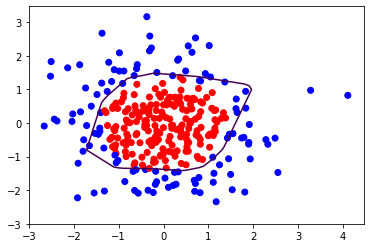

In [2]:

# 读入数据/标签 生成x_train y_train
df = pd.read_csv('dot.csv')
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c'])

x_train = x_data
y_train = y_data.reshape(-1, 1)

Y_c = [['red' if y else 'blue'] for y in y_train]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型问题报错
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)

# from_tensor_slices函数切分传入的张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

# 生成神经网络的参数，输入层为4个神经元，隐藏层为32个神经元，2层隐藏层，输出层为3个神经元
# 用tf.Variable()保证参数可训练
w1 = tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01, shape=[11]))

w2 = tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01, shape=[1]))

lr = 0.01  # 学习率为
epoch = 400  # 循环轮数

# 训练部分
for epoch in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:  # 记录梯度信息

            h1 = tf.matmul(x_train, w1) + b1  # 记录神经网络乘加运算
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1, w2) + b2

            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_mse = tf.reduce_mean(tf.square(y_train - y))
            # 添加l2正则化
            loss_regularization = []
            # tf.nn.l2_loss(w)=sum(w ** 2) / 2
            loss_regularization.append(tf.nn.l2_loss(w1))
            loss_regularization.append(tf.nn.l2_loss(w2))
            # 求和
            # 例：x=tf.constant(([1,1,1],[1,1,1]))
            #   tf.reduce_sum(x)
            # >>>6
            # loss_regularization = tf.reduce_sum(tf.stack(loss_regularization))
            loss_regularization = tf.reduce_sum(loss_regularization)
            loss = loss_mse + 0.03 * loss_regularization #REGULARIZER = 0.03

        # 计算loss对各个参数的梯度
        variables = [w1, b1, w2, b2]
        grads = tape.gradient(loss, variables)

        # 实现梯度更新
        # w1 = w1 - lr * w1_grad
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 每200个epoch，打印loss信息
    if epoch % 20 == 0:
        print('epoch:', epoch, 'loss:', float(loss))

# 预测部分
print("*******predict*******")
# xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01,生成间隔数值点
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
# 将xx, yy拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)
# 将网格坐标点喂入神经网络，进行预测，probs为输出
probs = []
for x_predict in grid:
    # 使用训练好的参数进行预测
    h1 = tf.matmul([x_predict], w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1, w2) + b2  # y为预测结果
    probs.append(y)

# 取第0列给x1，取第1列给x2
x1 = x_data[:, 0]
x2 = x_data[:, 1]
# probs的shape调整成xx的样子
probs = np.array(probs).reshape(xx.shape)
plt.scatter(x1, x2, color=np.squeeze(Y_c))
# 把坐标xx yy和对应的值probs放入contour<[‘kɑntʊr]>函数，给probs值为0.5的所有点上色  plt点show后 显示的是红蓝点的分界线
plt.contour(xx, yy, probs, levels=[.5])
plt.show()

# 读入红蓝点，画出分割线，包含正则化
# 不清楚的数据，建议print出来查看 